In [1]:
# Haoyang Chen
# hc2812
# Assingment 2

import numpy as np
import scipy as sp
from scipy.stats import norm
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
path = 'hw2_data_csv/'
# Training data
xtrn =pd.read_csv(path+'Xtrain.csv', header=None)
xtrn = xtrn.values
ytrn =list(pd.read_csv(path+'ytrain.csv', header=None)[0])

# Reading test data
xtst =pd.read_csv(path+'Xtest.csv', header=None)
xtst = xtst.values
ytst =list(pd.read_csv(path+'ytest.csv', header=None)[0])

Q = pd.read_csv(path+"Q.csv", header=None)
Q = Q.values

In [4]:
class probit_regression(object):
    def __init__(self, n, dim, sigma, lambda_var):
        self.n = n
        self.dim = dim
        self.sigma = sigma
        self.lambda_var = lambda_var
        self.W = []
        self.W.append(np.zeros(dim))
    
    def E_step(self, t, X, Y):
        sigma = self.sigma
        Expectation = []
        for i in range(X.shape[0]):
            Xw = np.dot(X[i], self.W[t-1])
            if Y[i] == 1:
                temp = Xw + sigma * norm.pdf(-Xw/sigma) / (1 - norm.cdf(-Xw/sigma))
                Expectation.append(temp)
            else:
                temp = Xw + sigma * (-norm.pdf(-Xw/sigma)) / norm.cdf(-Xw/sigma)
                Expectation.append(temp)
        self.Expectation = np.asarray(Expectation)
        
    def M_step(self, t, X):
        sigma = self.sigma
        lambda_var = self.lambda_var
        I = np.diag(np.ones(self.dim))
        xxt = np.dot(X.T,X) 
        temp = np.dot(np.linalg.inv(lambda_var * I + np.divide(xxt,sigma**2.0)), np.divide(np.dot(X.T,self.Expectation),sigma**2.0))
        self.W.append(temp)
    
    def log_joint_dist(self, t, X, Y):
        lambda_var = self.lambda_var
        sigma = self.sigma
        d = self.dim
        wt = self.W[t]
        Xw_over_sigma = np.divide(np.dot(X,wt).reshape((self.n,1)), sigma)
        ytrn = np.asarray(Y)
        temp = float((d/2.0) * np.log(lambda_var / (2.0*np.pi)) - (lambda_var/2.0) * np.dot(wt,wt)
               + np.dot(ytrn,np.log(norm.cdf(Xw_over_sigma))) + np.dot((1.0-ytrn),np.log(1.0 - norm.cdf(Xw_over_sigma))))
        return temp
    
    def fit(self, T, X, Y):
        log_joint_dist_val = -float('inf')
        self.log_joint_dist_val = []
        for t in range(1, T + 1):
            self.E_step(t, X, Y)
            self.M_step(t, X)
            temp = self.log_joint_dist(t, X, Y)
            if temp < log_joint_dist_val:
                print "error"
                break
            else:
                self.log_joint_dist_val.append(temp)
                log_joint_dist_val = temp
    
    def predict(self, T, X, Y, Xtest):
        self.fit(T, X, Y)
        weights = self.W[T]
        y_probs = np.dot(Xtest, weights)
        y_labels = [0 if y_prob <= 0 else 1 for y_prob in y_probs]
        self.y_hat = y_labels
        self.y_probs = y_probs
        return y_labels, y_probs
    
    
    def plot_joint_dist(self, T):
        t = list(range(1, T + 1))
        plt.plot(t, self.log_joint_dist_val)
        plt.xlabel('Iteration')
        plt.ylabel('Log Probability')
        plt.savefig('LogProbability.png')
        plt.show()
    
    def ConfusionMatrix(self, ytest):
        y = ytest
        y_hat = self.y_hat
        count_0_0 = 0
        count_0_1 = 0
        count_1_0 = 0
        count_1_1 = 0
        for i in range(len(y)):
            if (y[i] == 1) & (y_hat[i] == 1):
                count_1_1 += 1
            elif (y[i] == 0) & (y_hat[i] == 1):
                count_0_1 += 1
            elif (y[i] ==  1) & (y_hat[i] == 0):
                count_1_0 += 1
            elif (y[i] ==  0) & (y_hat[i] == 0):
                count_0_0 += 1
        
        print count_0_0, count_0_1, count_1_0, count_1_1
        print "Accuracy", (count_0_0 + count_1_1) / float(sum([count_0_0, count_0_1, count_1_0, count_1_1]))
    
    def ImageDrawer(self, Q, X, index):
        vector = X[index].reshape(15)
        img = np.dot(Q, vector).reshape((28,28))
        plt.imshow(img, interpolation='nearest')
        plt.savefig('img' + str(index) + '.png')

    def misclassfied(self, Q, X, ytest):
        ytst = ytest
        y_test = self.y_hat
        misclassfied_index = [i for i in range(len(y_test)) if y_test[i] != ytst[i]]
        print misclassfied_index[1]
        self.ImageDrawer(Q, X, misclassfied_index[1])
        print misclassfied_index[10]
        self.ImageDrawer(Q, X, misclassfied_index[10])
        print misclassfied_index[20]
        self.ImageDrawer(Q, X, misclassfied_index[20])
        
    def mostAmbiguous(self, Q, X):
        prob_abs = [abs(item - 0) for item in self.y_probs]
        sorted_prob = sorted(prob_abs)
        print prob_abs.index(sorted_prob[0]), norm.cdf(self.y_probs[prob_abs.index(sorted_prob[0])])
        self.ImageDrawer(Q, X, prob_abs.index(sorted_prob[0]))
        print prob_abs.index(sorted_prob[1]), norm.cdf(self.y_probs[prob_abs.index(sorted_prob[1])])
        self.ImageDrawer(Q, X, prob_abs.index(sorted_prob[1]))
        print prob_abs.index(sorted_prob[2]), norm.cdf(self.y_probs[prob_abs.index(sorted_prob[2])])
        self.ImageDrawer(Q, X, prob_abs.index(sorted_prob[2]))
        
    def reconstrucW(self, Q):
        for t in [1, 5, 10, 25, 50, 100]:
            W = self.W[t]
            img = np.dot(Q, W).reshape((28,28))
            plt.imshow(img, interpolation='nearest')
            plt.savefig('W' + str(t) + '.png')
            

In [5]:
n, dim = xtrn.shape
sigma = 1.5
lambda_var = 1
T = 100

In [6]:
model = probit_regression(n, dim, sigma, lambda_var)

In [7]:
y_labels, y_probs = model.predict(T, xtrn, ytrn, xtst)

In [8]:
model.ConfusionMatrix(ytst)

930 52 77 932
Accuracy 0.935208437971


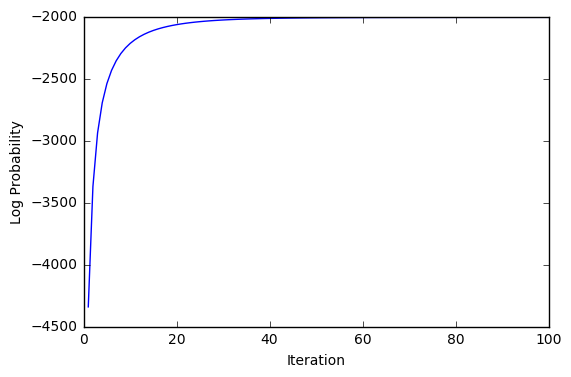

In [9]:
model.plot_joint_dist(T)

46
156
259


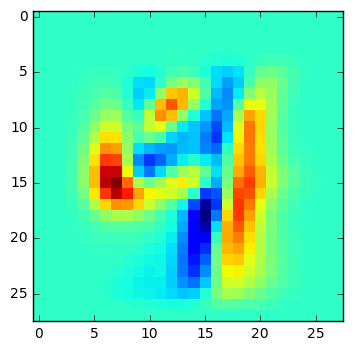

In [10]:
model.misclassfied(Q, xtst, ytst)

586 0.500260494859
340 0.504649686656
210 0.506175874801


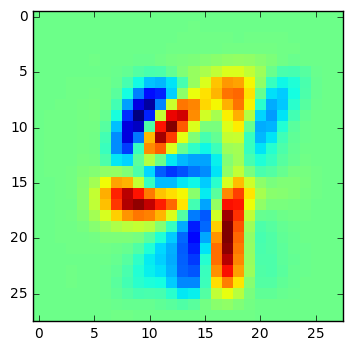

In [11]:
model.mostAmbiguous(Q, xtst)

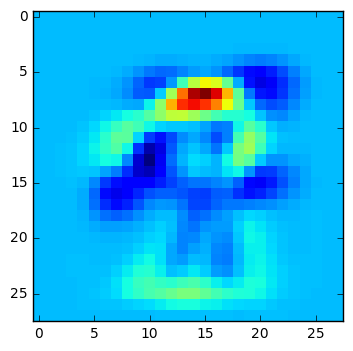

In [12]:
model.reconstrucW(Q)

In [26]:
model.y_hat[340]

1

In [27]:
ytst[340]

0